# Multilabel Classification with DocHate tips


When journalists ask their audience for help, success creates a whole new problem: what do you do with thousands of tips? 

Or what do you do with thousands of textual descriptions of … anything … potholes, disciplinary actions at prisons, aircraft safety incidents? There are too many to really read.

And any time you feel "there are too many to really read," that's when you should consider getting help from machine learning.

The folks at ProPublica’s Documenting Hate project had this problem, with around 6,000 tips about hate crimes and bias incidents contributed by readers. To report a hate incident, someone only has to provide a written description of what happened. If they choose, they can also fill out checkboxes for why the victim was targeted -- e.g. because of their race, religion or immigrant status.

Only some people include that “targeted because” checkbox, but that data is important for analysis and for getting tips to the right reporter. Could we train a computer to guess at what kind of target was involved based on the written description alone?

**This notebook is technical and gets into the nitty-gritty of how to do text classification in this context. If you'd like a less-technical overview, read [our blogpost](https://qz.ai/a-crash-course-for-journalists-in-classifying-text-with-machine-learning/).** Check out the interactive example of the Naive Bayes model here: [demo](https://s3.amazonaws.com/qz-aistudio-public/dochate.html).

We used Python and the scikit-learn library. (And tested some other algorithms using Keras.) But all of this is doable in R or other programming/stats languages. 

Here's what the final results look like, for predicting whether a tip is related to race and/or ethnicity using a variety of algorithms:

````
                     AU PR Curve
  Keras CNN             92
  Naive Bayes           90
  Spacy                 88
  Google AutomML        87
  Keras NN              84
  Keras LSTM             -
````  

It goes without saying, but, **be aware that there are slurs, swear words, and other offensive language in the code and output here!**

## Step 1: Figuring out what question we wanted to answer.

ProPublica receives tips about hate crimes via a [web form](http://documentinghate.com). The `targeted_because` checkboxes are optional. To fiddle with text classification approaches that work well for this kind of data (short-ish, political topics, etc.), we're going to try to "fill in the blanks" when the value of the `targeted_because` field is empty. 


In [1]:
# let's get started!
from os import environ
import numpy as np
import tensorflow as tf
import random

# several of the algorithms we test here make use of randomness. and we split the data into train/test groups randomly.
# in order to make sure that every time we run this notebook, we get the same results (rather than a
# "good" split making one algorithm choice seem better), we set an arbitrary number (1234) as the seed for all the 
# random number generators.
RANDOM_SEED = 1234
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)
environ['PYTHONHASHSEED'] = '0'

from tensorflow import keras
import pandas as pd
import spacy
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, precision_recall_curve, classification_report
nlp = spacy.load('en_core_web_lg')
from sklearn.preprocessing import  MultiLabelBinarizer
from imblearn.over_sampling import SMOTE

In [4]:
tips_raw = pd.read_csv("data/dochate/CleanReport-2019-02-13.csv") # the actual file is confidential. see "step 2"
print("Tips count: {}".format(tips_raw.shape[0]))
print("Columns: {}".format(tips_raw.columns.tolist()))

Tips count: 5943
Columns: ['admin_url', 'links', 'source', 'city', 'state', 'incident_date', 'where_occurred', 'type', 'targeted_because', 'gender', 'religion', 'race_ethnicity', 'reported_to_police', 'police_dept', 'description', 'knowledge', 'status']


## Step 2: Getting our data

We have our "train_test" data and our "real" data all mixed in one spreadsheet (along with out-of-scope data, like trolls, inapplicable data like those in Spanish and those with a blank `description`.). Our actual goal is to predict the column values where it's absent, using just the description field. 

I can't show you the data itself, but the descriptions are just text.  The `targeted_because` column is comma-separated, so it might say `race,ethnicity` or `religion,sexual-orientation,race`.

We remove the trolls, the not-applicable tips, those without a description and those that are in Spanish.

We split the remaining data into two groups. First `real_data` the remaining tips where there were no targeting reasons selected. Those are the ones where we want the computer to find the right answer. Second, `train_test_data` is tips that do have a targeting reason provided by the tipster.

In [6]:
column_of_interest = "targeted_because"


# remove all the tips that were marked by hand as trolls or not-applicable or with a blank description.
tips = tips_raw[(tips_raw["status"] != 'troll') & (tips_raw["status"] != 'not-applicable') & tips_raw["description"].notnull()]


# remove duplicates (of which there are some!)
tips_raw = tips_raw.drop_duplicates(subset=['description', column_of_interest], keep=False)


# this is a hacky way of detecting if a tip is in English or in Spanish. 
# stopwords are standard lists of grammatical function words ("a", "the", "of"). 
# If tip has more than 2 Spanish stopwords for every 3 English ones, we exclude it.
# It's not perfect but it works okay.
def is_english(sentence):
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    tokens_set = set(word_tokenize(sentence))
    return len(set(stopwords.words('english')) & tokens_set) * 1.5 > len(set(stopwords.words('spanish')) & tokens_set )
tips['english'] = tips['description'].apply(lambda x: is_english(x))
tips = tips[tips['english'] != False]
tips = tips.reset_index()

# split the data into the data for training/testing our models -- and the "real life" data we hope to use our model to help with.
train_test_data = tips[ tips[column_of_interest].notnull() ].copy()    # if targeted_because isn't blank
real_data = tips[~tips.isin(train_test_data)].dropna(how='all').copy() # if it is.


print("Tips that need classification: {}".format(real_data.shape))
print("tips that have a classification already: {}".format(train_test_data.shape))


Tips that need classification: (568, 19)
tips that have a classification already: (3710, 19)


## Step 3. Cleaning the data to remove the things that might confuse a computer.

Data cleaning is one of the most important parts of real-world natural language processing, but it's underdiscussed for at least two reasons: it's completely unsexy and it's often different for every project. Data cleaning means removing stuff that might distract a computer and combining similar but not quite identical features so that they appear identical to the computer. A good way to think about data cleaning is to ask yourself what sorts of things in your data would be what _you_ would use to categorize the data.

An easy example is that we lowercase everything (in other words, making the not-quite-identical words "Then" and "then" identical by transforming the first to "then"), since we're working with text typed by internet users. And, we will remove punctuation and "non-word characters" because they're not likely to tell us much about what attribute a hate crime was targeted by. (Ask yourself, will commas tell us anything about hate crimes? Of course not.) These are very typical and built into the vectorizers... (so we don't have to do it). We may also want to remove common English words like "a" and "the" -- typically called "stopwords" -- this is sometimes automatic, but not always, so it's worth checking.

Other examples depend on your precise dataset. There's no recipe. You have to ask yourself what words will be a distraction to the model. Here's a harder example: Consider a database of press releases from US Congress that you're trying to categorize by topic (taxation, military, education, etc.). The model should pick out the phrases used frequently by members of Congress who talk about each topic a lot. Sometimes that's good ("deduction", for instance)... but sometimes that's bad, like the name of former Rep. Paul Ryan's press secretary. Those words aren't actually useful for determining if something is about taxation... especially if Ryan's replacement hires his staffer.

Data cleaning is the process of cogitating about the data and figuring out a way to remove the unhelpful stuff, but not the helpful stuff. This is task-specific; if we had a dataset of press releases about Wisconsin that contained Ryan's press releases but also ones from the Milwaukee Brewers that we were trying to classify into the politics or sports category, the presence of Ryan-related words like the name of his press secretary _would_ be useful. 

Additionally, since the Documenting Hate tip data was submitted by users, it’s possible that they made mistakes -- like marking a clearly religion-related hate crime as related to, say, gender. Or failing to select ‘immigrant’ as a category for an incident that involved the intersection of race and immigrant status. Once I had an initial model trained, I dug -- quite unscientifically -- through the data that the classifier gets wrong to see if there are some where the user-contributed answer (that we treat as ground-truth) might be wrong. We might want to change some of the answers ourselves or even merge categories. You don’t want the computer to “learn” someone else’s mistakes.

We can see what words are being fed into the Naive Bayes model with `vectorizer.vocabulary_.keys()`. Let's do that and take a look. They mostly look good, right? 

In [7]:
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
simple_vectorizer = TfidfVectorizer(lowercase=True) # 1,1 works well?
simple_vectorizer.fit(tips["description"])
words = list(simple_vectorizer.vocabulary_.keys())
random.shuffle(words)
print(', '.join(words[:125]))

cranky, 28th, decatur, designated, ezpass, reverting, tender, demonstrators, tellin, fundamental, closely, giampa, inferiors, replies, demarcate, regenerate, aprove, marxist, shoe, hallway, arabs, mart, shortest, purported, curbs, abqjew, palm, homosexuality, engange, waste, trigger, xbox, carbondale, cbp, breathe, superstition, martial, horribly, beware, netanyahu, breeds, 42nd, smythe, chuckle, attended, predators, corporation, potted, strangely, duffle, catty, harrasing, sacred, bt, leaf, revs, gecko, 1st, akbar, clarksville, muscle, advocating, meningioma, bucks, slack, americorps, fyre, hanging, offhand, efforts, agitators, paranormal, investgations, disected, humptulips, ranged, justin, bisexual, congress, marijuana, hoodie, philando, denver, marco, upholstery, for, unavailable, kenosha, 99485266, imperial, holt, parkersburg, kleeve, middletown, instagram, arbitrarily, swaztica, outpopulate, seminole, killing, considerado, spokesman, nuefeild, chugiak, escape, founded, clinical, 

But what if there are meaningful words that are absent from here, because they're removed by the cleaning process?

🤔🤔🤔


In [8]:
words_to_check = ["email", "e-mail", "t-shirt", "f**king"]
for word in words_to_check:
    print("is {} 'visible' to the computer? {}".format(word, word in simple_vectorizer.vocabulary_.keys()))

is email 'visible' to the computer? True
is e-mail 'visible' to the computer? False
is t-shirt 'visible' to the computer? False
is f**king 'visible' to the computer? False


I think you see where we're going here...

### Data Cleaning That Preserves Censored Slurs

What are some words that are really informative about hate crimes, but are frequently not spelled out? Slurs. Remember when we removed "non-word characters"? We might want to backtrack and keep some of them, e.g. when a slur is replaced with comics-style grawlixes ("F@#$!"), stars, dashes or transformed into, e.g., "the f-word" or "k**e".

Default text-cleaning rules will split words at hyphens, transforming the quite-informative "f-word" first into "f word", then it will remove one-letter words, so we're just left with "word"... which tells us basically nothing. Defaults are usually a good choice, but here's an example where they're not.

So lets find some examples in the dataset so we can try to make sure they're included.

In [18]:
import re
# find words that have one alphabetic character, then one or more non-alpha chars, then more alpha chars.
# (so this matches 'e-mail', 't-shirt', 'f***ing' but not 'anti-semitic')
bad_words = sorted(set([item for sublist in [res for res in [re.findall(r"(?i)(?<= )[a-z\u00C0-\u017Fâ€œ][^a-z0-9â€œ\u00C0-\u017F'’\.\s]+[a-z\u00C0-\u017Fâ€œ]+", tip) for tip in list(tips['description'].values)] if res] for item in sublist  if not re.match(r'^(?i)[A-Za-z][&-][A-Za-z]$', item)]))
list(bad_words)[5:10]

['B_t', 'C*NT', 'C-word', 'E=MC', 'F*****g']

Yeah okay. How're we gonna deal with that...

We can verify (with the `inspect` method) that the word "word" makes an input tip more likely to be related to race and less likely to be related to other topics (though it's far more of a drag on, say, the `religion` class than on `sexual-orientation`.)

I noodled around with this for a while... The solution didn't occur to me immediately and I tried a variety of things and changed my goals when it became clear I hadn't fully solved the problem. At the start, I just wanted words like `f-word`, `f****r`, etc. to be preserved in the data given to the classifier... by the end, I decided that I wanted as many different variants of censored words to be "collapsed" into the same token -- and into a token that was mostly understandable by a human (not gibberish). I also wanted to make sure that the censored words didn't get turned into an instance of an unrelated "normal" word.

What I came up with only acts on words that are a single alphabetic character followed by one or more non-alphabetic characters followed by one or more alphabetic characters. If the non-alphabetic character string is just one hyphen, it gets turned into `dash`, so if we see `t-shirt` we turn it into `tdashshirt`. Otherwise, we replace it with the first letter, `XXX` and the last letter of the word -- so that `f*cking` and `f***ing` end up collapsed to the same thing, `fXXXg`. 

Inevitably, I did a fair amount of futzing around here. For a while, my regex didn't realize characters with diacritics were letters, so it started censoring the Spanish word "pública". I also was initially matching words like "A&M", which had to be excluded.

The effect of this turned out not to be that great though (about half a percentage point improvement in AUC). 

In [19]:
import re
def collapse_censored_word(word):
    if re.match(r"(?i)[a-z\u00C0-\u017Fâ€œ]-[a-z\u00C0-\u017Fâ€œ]+", word): # if there's just one hyphen, e.g. t-shirt, f-ing...
        word = word.replace("-", "dash")
    else:
        word = word[0] + "XXX" + word[-1]
#     word = re.sub(r"(?i)([^a-zâ€œ\u00C0-\u017F0-9'’\.\s\-]+|-{2,})", "XXX", word)
    return word

censorable_word_regex = "[a-z\u00C0-\u017Fâ€œ][^a-z0-9â€œ\u00C0-\u017F'’\.\s]+[a-z\u00C0-\u017Fâ€œ]+"
def clean(text):
    potential_censored_words = re.findall(r"(?i)(?<=[ \(\"\'])" + censorable_word_regex, text) + re.findall("(?i)^" + censorable_word_regex, text)
    for word in potential_censored_words:
        text = text.replace(word, collapse_censored_word(word))
    return text.replace("“", '').replace("’s", " 's").replace("'s", " 's")

See how it works? Rather than just retaining "word", we retain something meaningful.

In [20]:
clean("Q-word is bad")

'Qdashword is bad'

In [21]:
# checking how many bad words are collapsed with this method
print("Total censored words: {}".format(len(bad_words)))
unified_bad_words = {}
for word, clean_word in [(word, collapse_censored_word(word)) for word in bad_words]:
    if clean_word not in unified_bad_words:
        unified_bad_words[clean_word] = []
    unified_bad_words[clean_word].append(word)
print("Total censored words after cleaning: {}".format(len(set( unified_bad_words.keys()))))

Total censored words: 120
Total censored words after cleaning: 73


Once we've come up with a way to clean the text that we like, we do it.

`lemmatize` relies on a library called Spacy. It removes verb endings from words -- on the theory that we learn more by treating "punch" and "punching" and "punched" as the same word, especially when we have a small dataset. It adds a few percentage points of AUPR for several of the classes (but not race_ethnicity) with NB. For CNN it improves or does nothing (and costs one percentage point in a few places; immigrant does worse with the default dropout1=0.02 but dropout1=0.01 fixes the problem)


In [22]:
def lemmatize(doc):
    return ' '.join([token.lemma_ for token in nlp(doc)])

train_test_data["description"] = train_test_data["description"].apply(clean)
train_test_data["description"] = train_test_data["description"].apply(lemmatize)

### Preparing to predict targeted_because

Right now, the `targeted_because` column is exactly as it was in our source data (except we removed the blanks rows, the trolls, etc.) -- that is, a string with commas. The "typical" format for machine-learning projects like this one is to have one column for each possible targeting reason (race, etc.) and then a `1` in that column for each description if it has that class and a `0` if it doesn't. 

You can do that however you like, but we're using the MultiLabelBinarizer class from scikit-learn.

I'm also adding the `race_ethnicity` column that's `1` (i.e. true) if the hate incident is classified as either `race` or `ethnicity`-related by the tipster. That's because I guess that some tipsters are going to mix them up, which'd confuse the computer. 

I wonder if merging `race` and `ethnicity` categories might be a good idea -- only because people may use the terms interchangably on the form in a way that the computer can't learn the nuanced distinction between them.


In [27]:
# split the comma-separated targeted_because column into an actual list.
train_test_data[column_of_interest] = train_test_data[column_of_interest].apply(lambda x: x.split(",") if type(x) != list else x)

# since we're doing a multi-label classification problem -- aka a single incident can involve targeting someone for 
# one or more of the possible labels (e.g. race AND religion AND immigrant status) -- we need to do some data preprocessing.
# 'disability', 'ethnicity', 'gender', 'immigrant', 'race', 'religion', 'sexual-orientation'
# we're actually going to be doing 7 classifiers, one to see if a description matches each label or not.
lb = MultiLabelBinarizer()
labels_df = pd.DataFrame(lb.fit_transform(train_test_data[column_of_interest]), columns=list(lb.classes_), index=train_test_data.index)
train_test_data_one_hot = pd.concat([train_test_data[["description", column_of_interest]], labels_df], axis=1)
# print(train_test_data_one_hot[[idx for idx in train_test_data_one_hot.columns if idx != 'description']])
train_test_data_one_hot["race_ethnicity"] = train_test_data_one_hot.apply(lambda x: 1.0 if x["race"] or x["ethnicity"] else 0.0, axis=1)
train_test_data_one_hot[["description", "race_ethnicity"]].to_csv("data/dochate/dochate_for_automl.csv", header=False, index=False)
unique_classes = list(set([item for sublist in train_test_data[column_of_interest].values for item in sublist])) + ["race_ethnicity"]

So here's our data looks like now.

````
                      description                race           gender     ...
0     I was the victim of a hate crime.            0               1
1     I also was a hate crime victim.              1               0
````

Before we get started with actual machine learning, this is how many hate incidents of each class we have. It's generally harder to predict classes that have fewer examples. (The computer, which is quite dumb, never learns what words from the 129 disability-related reports indicate it's a disability-related report as opposed to a word that happens to be included in the report, like a city name.) That's why we don't do a great job with guessing which tips have to do with disability or gender.

In [28]:
#  are any of these columns so rare as to be useless to try to predict?
from itertools import groupby
all_values = [item for sublist in train_test_data["targeted_because"].values for item in sublist]
total = len(train_test_data)
for cnt, label in [(len(list(g)), k) for k, g in groupby((sorted(all_values)))]:
    print("{}: {} / {}   |  {}%".format(label.rjust(18), str(cnt).rjust(len(str(total))), total, round(cnt / float(total) * 100) ))

print("{}: {} / {}".format("race_ethnicity".rjust(18), str(len(train_test_data[train_test_data_one_hot["race_ethnicity"] == 1.0])).rjust(len(str(total))), total)) 

        disability:  127 / 3710   |  3%
         ethnicity: 1236 / 3710   |  33%
            gender:  374 / 3710   |  10%
         immigrant:  745 / 3710   |  20%
              race: 1838 / 3710   |  50%
          religion:  948 / 3710   |  26%
sexual-orientation:  655 / 3710   |  18%
    race_ethnicity: 2428 / 3710


## Step 4. Choosing an algorithm

Naive Bayes is a simple machine-learning technique (i.e. there's no calculus) but it works well. It's what we're trying first.

Later in this notebook, I'll be trying several algorithms for two reasons (a) as a learning exercise and (b) because machine learning is often such that one algorithm will mysteriously work better than others for a given task, just for idiosyncratic reasons, so it can be worthwhile to try several. Be aware that a lot of them require the data to be in different formats -- that’s step 4 -- so it requires a little extra work.

I’d lean towards picking simpler algorithms over more complex ones… especially if you have relatively little data.

### Here are the algorithms I tried.

 - Naive Bayes
 - a ‘vanilla’ neural net
 - a convolutional neural network
 - an LSTM neural network
 - Google’s NLP AutoML
 - Spacy’s text classification

Spoiler alert: the convolutional neural net works a tiny bit better than naive Bayes, but only a touch. And it's more complicated.

For each algorithm, we will do the next two steps:

5. Formatting the data in the way that your chosen algorithm requires it. 
6. Feeding most of your data to your algorithm and perhaps waiting a few minutes.

## Naive Bayes

This is a pretty basic classification algorithm, but it worked well in my experimentation.

We're actually doing seven classifiers, one for each of those options, predicting if a given description matches `race` or not, another predicting if it matches `sexual-orientation` or not, etc.

In [30]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from os.path import join
from os import makedirs
import pickle

### Step 5: Formatting the data in the way that our chosen algorithm requires it. 

At this point, our tips are in English. But computers can’t read! So we’re going to have to modify the data to a particular “format” for Naive Bayes.

That algorithm requires words to be represented by numbers -- a process called vectorizing.

I used the scikit-learn package’s TfidfVectorizer to do this, after experimenting with the HashingVectorizer and CountVectorizer. (The performance was about the same.) TfidfVectorizer transforms each tip into a list of numbers: reflecting the TF-IDF score for each token (aka word) in that tip (calculated against the entire corpus of all tips). Implicitly, each position into the list refers to an individual word -- and most of the entries in the list are 0, for words that exist in our dataset, but not in this particular tip. So a "vectorized" tip might look like this:

```
[0.1, 0, 0, 0, 0, 0.2, 0.11, 0, 0, 0]
```

The vectorizers also have the option to generate "n-grams" -- aka pairing together 2 or 3 word chunks and treating them as tokens too. For instance, the word "my" and the word "country" might not be informative about the tip of hate incident alone, but when they occur together, "my country" is probably a strong sign of an immigration-related incident. This tactic is often successful, but it gave worse results here.

We also split our data into two groups: training data and test data. Won’t the model do better with more training data? Yes, but we keep some portion to the side, so we can evaluate how the model did, with data it wasn’t trained on (but that we know the right answers for).

In [31]:
def equalize_classes(predictor, response):
    return SMOTE(random_state=RANDOM_SEED).fit_sample(predictor, response)


train_df, test_df = train_test_split(train_test_data_one_hot, 
                                     test_size=0.2, 
                                     shuffle=True,
                                     random_state=RANDOM_SEED)

train_features_nb = train_df["description"]
test_features_nb = test_df["description"]

vectorizer = TfidfVectorizer(ngram_range=(1,1),   # 1,1 works well?
                             # max_features=5000, # works best with max_features set to None.
                             lowercase=True)      # automatically lowercase each word.
vectorizer.fit(train_features_nb)

train_features_nb_vec = vectorizer.transform(train_features_nb)
test_features_nb_vec = vectorizer.transform(test_features_nb)

print("what (part of) a vectorized tip looks like: ")
print(train_features_nb_vec[0].toarray()[0].tolist()[200:250])



what (part of) a vectorized tip looks like: 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


### Step 6: Feeding most of your data to your algorithm and perhaps waiting a few minutes.

Finally! Let's train our model. We'll actually train seven models, one for each of our classes.

This is the part where the computer is learning. And it’s pretty simple, from your perspective. It's this line: `naivebayes_classifier.fit(train_features_nb_vec, train_labels_nb)`. 

For each of our classes, we have differing amounts of tips. For instance, we have 749 tips of incidents that involve immigrant status, out of 3732 total tagged tips, so 20%. This is a problem. Imagine if we had a very dumb model that predicted that nothing was immigrant-status related; it'd get 80% accuracy! So we have to "equalize" the imbalanced classes. We're doing that with SMOTE oversampling (but there are other options).



In [64]:
classifiers = {}
print("Training models for ...")
for class_of_interest in [col for col in train_test_data_one_hot.columns if col != "description" and col != 'targeted_because']:
    print(" - " + class_of_interest)
    naivebayes_classifier = MultinomialNB()
    train_labels_nb = train_df[class_of_interest]
    test_labels_nb = test_df[class_of_interest]

    train_features_equalized_nb_vec, train_labels_equalized_nb = equalize_classes(train_features_nb_vec, train_labels_nb)

    naivebayes_classifier.fit(train_features_equalized_nb_vec, train_labels_equalized_nb) # <-- TRAINING

    classifiers[class_of_interest] = naivebayes_classifier


Training models for ...
 - disability
 - ethnicity
 - gender
 - immigrant
 - race
 - religion
 - sexual-orientation
 - race_ethnicity


### Step 6. Looking at the results and deciding if it’s good enough or not -- and if it isn’t, repeating steps 2-6 as necessary.

So we're going to see how we did at the end of the next cell. But how do we know how well our model did?

`area under precision-recall curve` is a "metric" that's good for measuring classifiers with imbalanced classes -- a dataset is imbalanced when it isn't just 50% of one class and 50% of another, but instead has, say, 26% religion-related hate incidents and thus 74% non-religion-related. It's plotting precision (avoiding false positives) against recall (avoiding false negatives). The area under that curve is a proportion; the higher the better. If the area under the precision recall curve is significantly higher than the proportion of classses in our test data, then our model has learned to make a distinction between the two classes, however imperfectly.

In that example, you’d be comparing the area under the precision-recall curve to the proportion of your testing data that has the religion class -- if your model has more than 26% area under the precision-recall curve, it’s working. If it’s got a lot more than 26%, it’s working pretty well.

We also show the confusion matrix, which plots the model's guesses against the right answers. Bigger numbers in the top-left and bottom-right are better; the top-right is false negatives and top-left is false positives.

In [65]:
for class_of_interest in [col for col in train_test_data_one_hot.columns if col != "description" and col != 'targeted_because']:
    naivebayes_classifier = classifiers[class_of_interest]
    predicted_probabilities_nb = naivebayes_classifier.predict_proba(test_features_nb_vec)[:,1]
    predicted_labels_nb = [(1.0 if proba > 0.5 else 0.0) for proba in predicted_probabilities_nb]
#     print(confusion_matrix(test_labels_nb, predicted_labels_nb, labels=[1., 0.]))
    print()
    
    pr_baseline = float(len([a for a in test_labels_nb if a]))/len(test_labels_nb)
    pr_score = average_precision_score(test_labels_nb, predicted_probabilities_nb)
    print(class_of_interest)
    print("area under  PR curve: ", round(pr_score, 2))
    print("If the AUPR score ({}) is more than a little bigger than the baseline ({}), which it *{}*, then our model is working!".format(pr_score, pr_baseline, "is" if pr_score - (pr_baseline * 1.1) else "isn't" ))
    print()
    print() 


disability
area under  PR curve:  0.68
If the AUPR score (0.6807504776362596) is more than a little bigger than the baseline (0.6563342318059299), which it *is*, then our model is working!



ethnicity
area under  PR curve:  0.8
If the AUPR score (0.8002249439051338) is more than a little bigger than the baseline (0.6563342318059299), which it *is*, then our model is working!



gender
area under  PR curve:  0.63
If the AUPR score (0.6319593009558203) is more than a little bigger than the baseline (0.6563342318059299), which it *is*, then our model is working!



immigrant
area under  PR curve:  0.77
If the AUPR score (0.7732047968744618) is more than a little bigger than the baseline (0.6563342318059299), which it *is*, then our model is working!



race
area under  PR curve:  0.88
If the AUPR score (0.8807390613874166) is more than a little bigger than the baseline (0.6563342318059299), which it *is*, then our model is working!



religion
area under  PR curve:  0.55
If the AUPR sco

You can see a chart of the precision-recall curve below. If we had a different goal, we might rather have false positive than false negatives (or vice versa); the values of precision for each possible recall goal are what is plotted here.


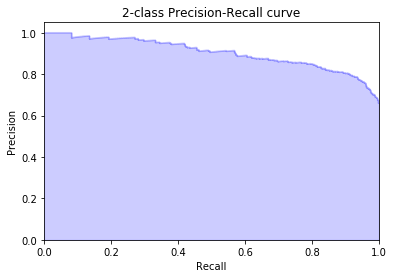

In [39]:
pr_chart(test_labels_nb, predicted_probabilities_nb)

## Keras Neural Nets
via https://www.tensorflow.org/tutorials/keras/basic_text_classification

Neural nets are very trendy and for good reason: they're very powerful and can "learn" patterns that are too complicated for Naive Bayes.

Neural nets are a category, not an individual model algorithm. We're going to try two different ones:

 - a basic neural net
 - a convolutional neural net
 
Both networks learn "embeddings" for each word in our tips. These are akin to word2vec-style vectors, but where those vectors are trained on a large general-purpose dataset, ours are trained just for this purpose (and trained on a lot less data). I tried using word2vec vectors, but it didn't work as well. The vectors are equivalent to the output of the TfidfVectorizer that we used for Naive Bayes.

The convolutional neural net does better than the basic one, likely because it takes into account each word's context.

(I also tried an LSTM, but I couldn't get it to work! I suspect because I don't have enough data.)

Here's some shared settings for both kinds of models.

In [45]:
from __future__ import absolute_import, division, print_function
WORDS_TO_KEEP = 10000 # should really be 10000
tokenizer = keras.preprocessing.text.Tokenizer(num_words=WORDS_TO_KEEP)
VALIDATION_SET_SIZE = 1000
SHOULD_EQUALIZE = True
VOCAB_SIZE = WORDS_TO_KEEP + 3
MAX_SEQUENCE_LENGTH = 256

### Step 5: Formatting the data in the way that our chosen algorithm requires it. 

Unlike Naive Bayes, the neural nets take the words as a list of numbers, where each number corresponds directly to a token (aka word). Each list has to be the same length, so we have a special character for padding that gets added at the end of shorter tips. So a tip encoded for Keras might look like. `[46, 3449, 9, 172, 15, 6, 1054, 0, 0, 0 ... 0, 0]`

In [46]:
# via https://www.tensorflow.org/tutorials/keras/basic_text_classification
train_df, test_df = train_test_split(train_test_data_one_hot, test_size=0.2, shuffle=True, random_state=RANDOM_SEED)

tokenizer.fit_on_texts(train_test_data_one_hot["description"])
print("We have {} total words.".format(max(tokenizer.word_index.values())))

word_index = {k:(v+3) for k,v in tokenizer.word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_text(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
def encode_texts(texts):
    return [[word_index['<START>']] + [idx + 3 for idx in list(idxs)] for idxs in tokenizer.texts_to_sequences(texts)[:]]
def encode_text(text):
    return encode_texts([text])[0]

We have 16135 total words.


These are some helper methods we'll use for all the kinds of neural nets. The `train_keras_model` method combines steps 4-6: preparing the input data, training the model, and printing out evaluation stats.

In [50]:
def equalize_classes_keras(predictor, response):
    return SMOTE(random_state=RANDOM_SEED).fit_sample(predictor, response)

def train_keras_model(model_fn, train_df, test_df, epochs=40, should_equalize=SHOULD_EQUALIZE, classes_of_interest=None):
    # several of the algorithms we test here make use of randomness. and we split the data into train/test groups randomly.
    # in order to make sure that every time we run this notebook, we get the same results (rather than a
    # "good" split making one algorithm choice seem better), we set an arbitrary number (1234) as the seed for all the 
    # random number generators.
    keras.backend.clear_session()
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
    
    histories = {}

    # preparing the input data.
    train_data = np.array(encode_texts(train_df["description"]))
    test_data = np.array(encode_texts(test_df["description"]))
    train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                            value=word_index["<PAD>"],
                                                            padding='post',
                                                            maxlen=256)
    test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                           value=word_index["<PAD>"],
                                                           padding='post',
                                                           maxlen=256)
    for class_of_interest in classes_of_interest:
        train_labels = train_df[class_of_interest]
        test_labels = test_df[class_of_interest]

        if should_equalize:
            equalized_train_data, equalized_train_labels = equalize_classes_keras(train_data, train_labels)
        else:
            equalized_train_data = train_data.copy()
            equalized_train_labels = train_labels.copy()

        x_val = equalized_train_data[:VALIDATION_SET_SIZE]
        partial_x_train = equalized_train_data[VALIDATION_SET_SIZE:]

        y_val = equalized_train_labels[:VALIDATION_SET_SIZE]
        partial_y_train = equalized_train_labels[VALIDATION_SET_SIZE:]
        model = model_fn()
        print(class_of_interest)
        history = model.fit(partial_x_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=256,
                            validation_data=(x_val, y_val),
                            verbose=0
                           )
        results = model.evaluate(test_data, test_labels)
        histories[class_of_interest] = history
        predicted_probabilities = model.predict(test_data)
        predicted_labels = [1.0 if proba > 0.5 else 0.0 for proba in predicted_probabilities]
        # print(confusion_matrix(test_labels, predicted_labels, labels=[1., 0.]))
        pr_score    = average_precision_score(test_labels, predicted_probabilities)
        pr_baseline = float(len([a for a in test_labels if a]))/len(test_labels)
        print("Area under  PR curve: ", round(pr_score, 2))
        print("If the AUPR score ({}) is more than a little bigger than the baseline ({}), which it *{}*, then our model is working!".format(round(pr_score, 2), round(pr_baseline, 2), "is" if pr_score - (pr_baseline * 1.1) else "isn't" ))

        print()
        print()
    return [histories, test_labels, predicted_probabilities]

In [51]:
def embedding_layer(word2vec=False):
    if word2vec: 
        EMBEDDING_DIM = 200
        from gensim.models import Word2Vec
        w2v = Word2Vec.load("my_word2vec_model.bin")
        embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
        for word, i in word_index.items():
            embedding_vector = w2v[word.lower()] if word in w2v else None
            if embedding_vector is not None:
                # words not found in embedding index will be all-zeros.
                embedding_matrix[i] = embedding_vector

        return keras.layers.Embedding(len(word_index) + 1,
                                  EMBEDDING_DIM,
                                  weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH,
                                  trainable=False) # 
    else: 
        return keras.layers.Embedding(VOCAB_SIZE, 16)


### Basic Keras NN

This is a very basic neural net. 

In [54]:
def basic_model():
    model = keras.Sequential()
    model.add(embedding_layer())
    model.add(keras.layers.GlobalAveragePooling1D())
    model.add(keras.layers.Dense(16, activation=tf.nn.relu))
    model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # model.summary()
    return model

As you can see, this model doesn't do as well as Naive Bayes. It also takes a lot longer to train, hence the progress bars.

In [55]:
histories, test_labels, predicted_probas = train_keras_model(basic_model, train_df, test_df, epochs=5, classes_of_interest=list(set(all_values)) + ['race_ethnicity'])

742/742 [==============================] - 0s 32us/sample - loss: 0.7459 - acc: 0.2615
religion
Area under  PR curve:  0.34
PR Baseline         :  0.24123989218328842
If the AUPR score (0.34) is more than a little bigger than the baseline (0.24), which it *is*, then our model is working!


742/742 [==============================] - 0s 43us/sample - loss: 0.7171 - acc: 0.3518
ethnicity
Area under  PR curve:  0.43
PR Baseline         :  0.35175202156334234
If the AUPR score (0.43) is more than a little bigger than the baseline (0.35), which it *is*, then our model is working!


742/742 [==============================] - 0s 35us/sample - loss: 0.8048 - acc: 0.1685
sexual-orientation
Area under  PR curve:  0.17
PR Baseline         :  0.16711590296495957
If the AUPR score (0.17) is more than a little bigger than the baseline (0.17), which it *is*, then our model is working!


742/742 [==============================] - 0s 84us/sample - loss: 0.8311 - acc: 0.1105
gender
Area under  PR curve: 

## Keras CNN:



### Step 6. Looking at the results and deciding if it’s good enough or not -- and if it isn’t, repeating steps 2-6 as necessary.

Convolutional neural nets were revolutionary in how they improved neural nets' performance with text by examining several words at once. Other people undoubtedly would do a better job explaining how that works!

While the performance of CNNs can be great, they have a LOT of settings that you can fiddle with to change how well they do. Learning rates, embedding dimensions, the number of epochs, etc. And they even depend on starting off with a certain amount of randomness, so running the same model twice on the same data (if you're not careful) can get you different results! 

Other tutorials will do you a better job explaining how to do that too, though below I discuss using a "grid search" to try to help.

### repeatability

However, I went down the rabbithole of making my runs repeatable: this is really hard becuase there are several sources of randomness and Jupyter notebooks all happen within the same Python session. In the process, I learned something important about _keras_ sessions -- a model is built within a session, so when you train a model twice within the same session, you're really just (it seems?) training the same model at double the epochs. So to make stuff repeatable, we need to re-set the random seeds AND start a new session AND re-declare the model.
```
    keras.backend.clear_session()
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)
    tf.set_random_seed(RANDOM_SEED)
```

In [76]:
def cnn_model(learning_rate=0.001, dropout_embedding=0.0, dropout1=0.2, dropout2=0.2, dropout3=0.2, embedding_dim=32, num_filters=32, kernel_size=5 ):
    keras.backend.clear_session()

    adam = keras.optimizers.Adam(lr=learning_rate) # default lr = 0.001

    model = keras.Sequential()
    model.add(keras.layers.Embedding(VOCAB_SIZE, embedding_dim, input_length=MAX_SEQUENCE_LENGTH))
    # dropout here doesn't help.
    # model.add(keras.layers.Dropout(dropout_embedding))
    model.add(keras.layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(keras.layers.Dropout(dropout1)) # 0.4 works better than 0.5 here (but not dramatically); 0.3 does better than 0.4 maybe?, 0.2 actually does better than both (and better than NB, at 86/92)
    model.add(keras.layers.GlobalMaxPooling1D())
    model.add(keras.layers.Dropout(dropout2))
    model.add(keras.layers.Dense(10, activation='relu'))
    model.add(keras.layers.Dropout(dropout3))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    # model.summary()
    return model

In [77]:
histories_cnn, test_labels_cnn, predicted_probas_cnn = train_keras_model(cnn_model, train_df, test_df, epochs=20, should_equalize=False, classes_of_interest=(list(set(all_values))) +  ["race_ethnicity"]) # 

742/742 [==============================] - 0s 165us/sample - loss: 0.3474 - acc: 0.8747
religion
Area under  PR curve:  0.77
PR Baseline         :  0.24123989218328842
If the AUPR score (0.77) is more than a little bigger than the baseline (0.24), which it *is*, then our model is working!


742/742 [==============================] - 0s 170us/sample - loss: 0.5497 - acc: 0.7480
ethnicity
Area under  PR curve:  0.66
PR Baseline         :  0.35175202156334234
If the AUPR score (0.66) is more than a little bigger than the baseline (0.35), which it *is*, then our model is working!


742/742 [==============================] - 0s 164us/sample - loss: 0.2411 - acc: 0.9272
sexual-orientation
Area under  PR curve:  0.79
PR Baseline         :  0.16711590296495957
If the AUPR score (0.79) is more than a little bigger than the baseline (0.17), which it *is*, then our model is working!


742/742 [==============================] - 0s 203us/sample - loss: 0.3429 - acc: 0.8895
gender
Area under  PR cur

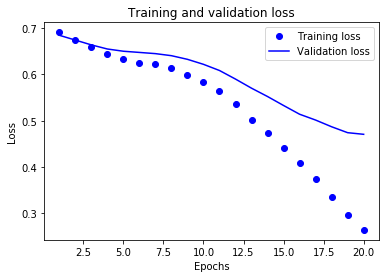

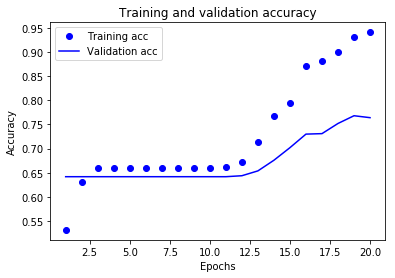

In [78]:
training_and_validation_loss(histories_cnn['race_ethnicity'])
training_and_validation_accuracy(histories_cnn['race_ethnicity'])

As you can see in the charts above, validation loss has begun to flatten out. We don't need more epochs. Since the training loss is very low, but validation loss is higher, that means we may be overfit.

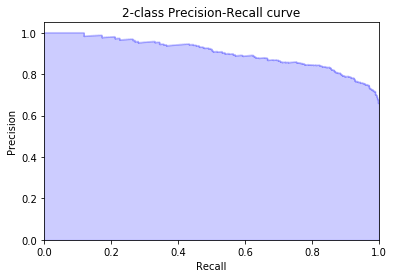

In [80]:
pr_chart(test_labels_cnn, predicted_probas_cnn)

## Keras LSTM:

LSTMs (short for Long Short-Term Memory) are another kind of neural network that works well on text. But for some reason, I couldn't get it to do much at all for this dataset. I got an area under PR curve of 0.66, with a baseline of 0.657...

In other words, the model was just guessing. 

I don't know why. If you do, let me know?


In [82]:
def lstm_model(learning_rate=0.001):
    keras.backend.clear_session()

    adam = keras.optimizers.Adam(lr=learning_rate) # default lr = 0.001

    model = keras.Sequential()
    model.add(
        keras.layers.Embedding(VOCAB_SIZE, # vocab size
                                    32,   # output size; embedding dimensions
                                   input_length=MAX_SEQUENCE_LENGTH
                              ))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.LSTM(100))
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Dense(1, activation='sigmoid')) # with just one dense layer, race_ethnicity ROC 0.69
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

In [83]:
histories, test_labels_lstm, predicted_probas_lstm = train_keras_model(lstm_model, train_df, test_df, epochs=5, should_equalize=True, classes_of_interest=["race_ethnicity"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 32)           320096    
_________________________________________________________________
dropout (Dropout)            (None, 256, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 373,397
Trainable params: 373,397
Non-trainable params: 0
_________________________________________________________________
742/742 [==============================] - 2s 2ms/sample - loss: 0.7263 - acc: 0.4084
race_ethnicity
Area under  PR curve:  0.69
PR Base

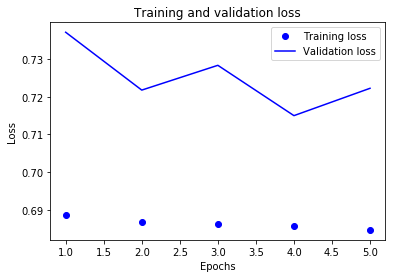

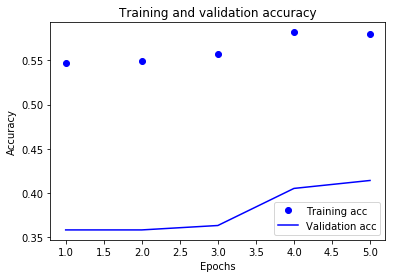

In [84]:
training_and_validation_loss(histories['race_ethnicity'])
training_and_validation_accuracy(histories['race_ethnicity'])

## Spacy Text Categorization
https://spacy.io/usage/examples#textcat
It's a CNN, but with smart defaults for a lot of the options.

In [85]:
from spacy.util import minibatch, compounding
from pathlib import Path

nlp_textcat = spacy.load('en_core_web_lg')

SHOULD_EQUALIZE_SPACY = True
VALIDATION_SET_PERCENTAGE = 0.2
output_dir = 'data/spacy/'
n_iter = 20 # 5 might be plenty?
COLUMN_OF_INTEREST_SPACY = "race_ethnicity"

train_df, test_df = train_test_split(train_test_data_one_hot, test_size=0.2, shuffle=True)

def load_data(limit=0, split=0.8, column=COLUMN_OF_INTEREST_SPACY):
    """Load data from the IMDB dataset."""
    # Partition off part of the train data for evaluation
    train_data = train_df[["description", column]]
    train_data = train_data.sample(frac=1).reset_index(drop=True)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data.values)
    cats = [{'POSITIVE-{}'.format(column): bool(y)} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0   # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0   # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}



if output_dir is not None:
    output_dir = Path(output_dir)
    if not output_dir.exists():
        output_dir.mkdir()

# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp_textcat.pipe_names:
    textcat = nlp_textcat.create_pipe('textcat')
    nlp_textcat.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp_textcat.get_pipe('textcat')

# add label to text classifier
label_name = 'POSITIVE-{}'.format(COLUMN_OF_INTEREST_SPACY)
textcat.add_label(label_name)

(train_texts, train_cats), (dev_texts, dev_cats) = load_data(split=1.0-VALIDATION_SET_PERCENTAGE)
print("Using {} examples ({} training, {} evaluation)"
      .format(len(train_texts) + len(dev_texts), len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp_textcat.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp_textcat.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp_textcat.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print('{4: <2}. {0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f'], i+1))


if output_dir is not None:
    with nlp_textcat.use_params(optimizer.averages):
        nlp_textcat.to_disk(output_dir)
    print("Saved model to", output_dir)

Using 2968 examples (2374 training, 594 evaluation)
Training the model...
LOSS 	  P  	  R  	  F  
1 . 128.089	0.726	0.908	0.807
2 . 64.358	0.795	0.847	0.820
3 . 39.252	0.789	0.858	0.822
4 . 27.853	0.802	0.853	0.827
5 . 19.732	0.801	0.868	0.833
6 . 15.693	0.801	0.858	0.828
7 . 12.891	0.795	0.868	0.830
8 . 10.547	0.800	0.866	0.832
9 . 8.722	0.804	0.866	0.834
10. 8.085	0.813	0.847	0.830
11. 7.108	0.815	0.868	0.841
12. 7.256	0.821	0.845	0.833
13. 6.614	0.820	0.850	0.835
14. 6.221	0.815	0.837	0.826
15. 5.845	0.812	0.839	0.825
16. 7.384	0.807	0.845	0.825
17. 6.187	0.806	0.853	0.829
18. 7.135	0.797	0.858	0.826
19. 5.674	0.802	0.863	0.831
20. 5.625	0.811	0.847	0.829
Saved model to data/spacy


In [116]:
from tqdm import tqdm_notebook as tqdm
predicted_probabilities = []
for row in tqdm(test_df[["description", COLUMN_OF_INTEREST_SPACY]].values):
    doc = nlp_textcat(row[0])
    predicted_probabilities.append(doc.cats["POSITIVE-{}".format(COLUMN_OF_INTEREST_SPACY)])
    
print("spaCy Area under  PR curve: ", average_precision_score(test_df[COLUMN_OF_INTEREST_SPACY], predicted_probabilities))



spaCy Area under ROC curve:  0.8214486024989873
spaCy Area under  PR curve:  0.8822858437821977


## Bonus #1: What confuses the classifier?

Let's loop through the test set and see for which documents the Naive Bayes classifier gives the wrong answer. Then we'll use our human judgment to see if the computer is really giving the 'wrong' answer or if the data is just coded wrong.

In some cases the person who submitted the tip didn't classify it in the way we'd want to. In that case, the computer's not really wrong.

In some cases, the computer is not giving the answer we want it to. Sometimes, that's "forgivable" and we can't expect it to (e.g. misspellings or descriptions that use unfamiliar wordings); other times, the model is _really_ doing the wrong thing. It's that last case that we're trying to eliminate overall.

But the purpose of this exercise is to get a sense of what the model is missing and what tips are mis-classified by humans. 

What I've noticed:

- the model doesn't seem to know the phrase "N word"; even though that should be a clear sign of a race-related tip. (Which I fix above).
- the model classifies many Judaism-related tips as non-race/ethnicity-related (when teh submitter classified it that way). In my opinion, that may be okay if the model categorizes those as religion-related. (But like, it's a tough category in the first place. If humans can't agree on the right answer, we can't expect the computer to settle it for us!)
- forgivable error "get out of the country" coded as race-related when person reporting is from England. (i.e. computer is picking up on a real signal that just happens not to apply here.)

In [ ]:
test_labels_nb = test_df_nb[class_of_interest]
test_features_nb = test_df_nb["description"]
test_features_nb_vec = vectorizer.transform(test_features_nb)

predicted_probabilities = nbclassifier.predict_proba(test_features_nb_vec)[:,1]
for (row, predicted_proba) in zip(test_df_nb[["description", class_of_interest]].values, predicted_probabilities):
    if row[1] == (1.0 if predicted_proba > 0.5 else 0.0):
        continue
    print("Classifier sez {}; gold-standard coded as {}".format(predicted_proba, row[1]))
    print("Text: {}".format(row[0]))
    print("\n---------------------------------------------\n")

`I can't actually show you the output.`

## Bonus #2. Interactive Example

We can figure out what words in a description contribute most to the score (again using Naive Bayes).

You can also see this code in an [interactive form here](https://s3.amazonaws.com/qz-aistudio-public/dochate.html).

For a tip, we remove each n-gram and run the modified tip through the classifier. The n-grams that, when removed, cause the largest change in the model's guess are the ones that have the biggest effect. This is kind of a hack: some models might take into account additional context than just trigrams or do so in different ways. But this gives us a sense of what the model is basing its decision on. 

You'll find some times when the model makes the right call... and other times where it has mistakenly learned that an  phrase that ought to be irrelevant has a big effect. (Can you think of why that might happen?)


In [67]:
import re

def classify_all(text, cutoff=0.5):
    classifications = []
    vectorized_text = vectorizer.transform([text])
    for class_of_interest, classifier in classifiers.items():
        proba = classifier.predict_proba(vectorized_text)[:,1][0]
        if proba > 0.50:
            classifications.append(class_of_interest)
    return classifications
        

def permute_text(text):
    words = ' '.join(re.sub(r'[^A-Za-z0-9]', ' ', text).split()).split()
    bigrams = list(zip(words[:-1], words[1:]))
    trigrams = list(zip(bigrams[:-2], words[2:]))
    return [(word, ' '.join(words[:i] + words[i+1:]) ) for i, word in enumerate(words)] + [(' '.join(bigram), ' '.join(words[:i] + words[i+2:]) ) for i, bigram in enumerate(bigrams)] + [( ' '.join(trigram[0] + (trigram[1],)), ' '.join(words[:i] + words[i+3:]) ) for i, trigram in enumerate(trigrams)]

def but_why_with_func(text, classify):
    baseline = classify(text)
    permuted_texts = permute_text(text)
    diffs = [(deleted_word, baseline - classify(permuted_text)) for (deleted_word, permuted_text)  in permuted_texts]
    biggest_diffs = sorted(diffs, key=lambda word_diff: -abs(word_diff[1]))[:4]
    return baseline, biggest_diffs 
  
def but_why(text, class_of_interest="race_ethnicity"):
    baseline, biggest_diffs = but_why_with_func(text, 
                    lambda x: classifiers[class_of_interest].predict_proba(vectorizer.transform([x]))[:,1][0])
    return baseline, biggest_diffs

def inspect(text, class_of_interest=None):
    text = clean(text)
    print("Text:")
    print()
    print("  " + text)
    print()

    print("Predicted targeted-because: ")
    for target in classify_all(text):
        print(' * ' + target)
    if class_of_interest: 
        print()
        print("Why that {} prediction?".format(class_of_interest))
        baseline, biggest_diffs = but_why(text, class_of_interest)
        print("predicted probability: {0:.2f}%".format(baseline * 100))
        print("top difference-makers:")
        for (deleted_word, diff) in biggest_diffs:
            print(" - {0}, {1:.2f}%".format(deleted_word, diff * 100))



In [69]:
text = "someone called me the n-word at the grocery store"
inspect(text, 'race_ethnicity')

Text:

  someone called me the ndashword at the grocery store

Predicted targeted-because: 
 * race
 * race_ethnicity

Why that race_ethnicity prediction?
predicted probability: 69.56%
top difference-makers:
 - ndashword at, 18.51%
 - the ndashword at, 18.47%
 - ndashword at the, 18.47%
 - ndashword, 18.08%


## Bonus 3: Grid Search for targeted_because

My CNN managed to slightly outperform Naive Bayes for predicting `targeted_because`. Let's see if we can fiddle with the knobs (technically "hyperparameters" -- settings like the size of the embedding layer, the learning rate or the dropout amount -- and get better results.

There's no science to this. We're just fiddling with knobs. Grid Search is a technique for fiddling with those knobs systematically...

This took a lot of fiddling (Tensorflow doesn't parallelize well, due to memory reservations that aren't easily freed. That's what a lot of random-seed setting code above does.)

I did this on a p3.2xlarge instance, which costs \\$3/hr and testing 11250 combinations 3x each, took 20hr 52min -- costing \\$60ish. (If you do everything right the first time, which I didn't.)

Results look like this: Best: 0.792443 using {'batch_size': 256, 'dropout1': 0.1, 'dropout2': 0.0, 'dropout3': 0.0, 'dropout_embedding': 0.0, 'embedding_dim': 32, 'epochs': 20, 'kernel_size': 5, 'learning_rate': 0.001, 'num_filters': 256, 'verbose': 0} plus results for every combination.

I used this tutorial: https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

The best result was  0.898847 using `{'batch_size': 256, 'dropout1': 0.0, 'dropout2': 0.1, 'dropout3': 0.2, 'dropout_embedding': 0.0, 'embedding_dim': 32, 'epochs': 30, 'kernel_size': 5, 'learning_rate': 0.0005, 'num_filters': 256, 'verbose': 0}`.

In [ ]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

keras.backend.clear_session()
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.set_random_seed(RANDOM_SEED)


should_equalize = False

histories = {}

train_data = np.array(encode_texts(train_df["description"]))
test_data = np.array(encode_texts(test_df["description"]))
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)
for class_of_interest in ["race_ethnicity"]:
    train_labels = train_df[class_of_interest]
    test_labels = test_df[class_of_interest]

    if should_equalize:
        equalized_train_data, equalized_train_labels = equalize_classes_keras(train_data, train_labels)
    else:
        equalized_train_data = train_data.copy()
        equalized_train_labels = train_labels.copy()

    x_val = equalized_train_data[:VALIDATION_SET_SIZE]
    partial_x_train = equalized_train_data[VALIDATION_SET_SIZE:]

    y_val = equalized_train_labels[:VALIDATION_SET_SIZE]
    partial_y_train = equalized_train_labels[VALIDATION_SET_SIZE:]
    
    # different bits
    parameters_cnn = {
        "learning_rate":      (0.001,),
        "dropout_embedding":  (0.0, 0.1, 0.2, 0.3, 0.4),
        "dropout1":           (0.0, 0.1, 0.2, 0.3, 0.4),
        "dropout2":           (0.0, 0.1, 0.2, 0.3, 0.4),
        "dropout3":           (0.0, 0.1, 0.2, 0.3, 0.4),
        "embedding_dim":      (16, 32),  # default 16
        "num_filters":        (32,64,256), # default 128
        "kernel_size":        (3,5,7),       # default 5

        # these aren't actually options we're messing around with parameters
        "epochs": (20,),
        "batch_size": (256,),
        "validation_data": [(x_val, y_val)],
        "verbose": (0,),
    }

    
    model = KerasClassifier(build_fn=cnn_model)    
    gridsearcher = GridSearchCV(model, parameters_cnn, scoring='average_precision', verbose=0, n_jobs=1)
    grid_result = gridsearcher.fit(partial_x_train, partial_y_train)
    
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, {k:v for k,v in grid_result.best_params_.items() if k != 'validation_data'}))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))


### some helpful methods for charting...

That are used above, but defined here just so that they're out of the way!

In [38]:
from sklearn.utils.fixes import signature
import matplotlib.pyplot as plt

def pr_chart(labels, predicted_probas):
    precision, recall, _ = precision_recall_curve(labels, predicted_probas)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve')

In [74]:
def training_and_validation_accuracy(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [75]:
import matplotlib.pyplot as plt

def training_and_validation_loss(history): 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()